**Data source:** https://www.ercot.com/gridinfo/load/load_hist

## The imports

In [2]:
#the usuals
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
from datetime import timedelta
from math import sqrt
import importlib
from tqdm import tqdm

# plots
from matplotlib import style
style.use('default')




# Modeling
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import load_model


# Our custom utility functions
import utils
utils = importlib.reload(utils) #reload if utils.py is modified.
from utils import csvfileread, read_and_rename,create_dataset,convert_timestamp

In [2]:
##Load the preprocessed data

In [3]:
# Data between 2018 and 2024 
data_path = "Data/"
files = glob.glob(data_path + "load_and_weather_data*")
df = pd.read_csv(files[0])

In [6]:
#filling missing values with linear interpolation
#PLEASE Interpolate only the columns you need -- you don't want timestamps col
#merged_df=merged_df.interpolate(method='linear')
df.columns
for col in df.columns:
    if col!='timestamp':
        #print(f'{col}')
        df[col] = df[col].interpolate(method='linear')

In [8]:
# Sort the DataFrame by index
df['timestamp']=pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)
df = df.sort_index()

In [10]:
df=df.drop(columns='Unnamed: 0')

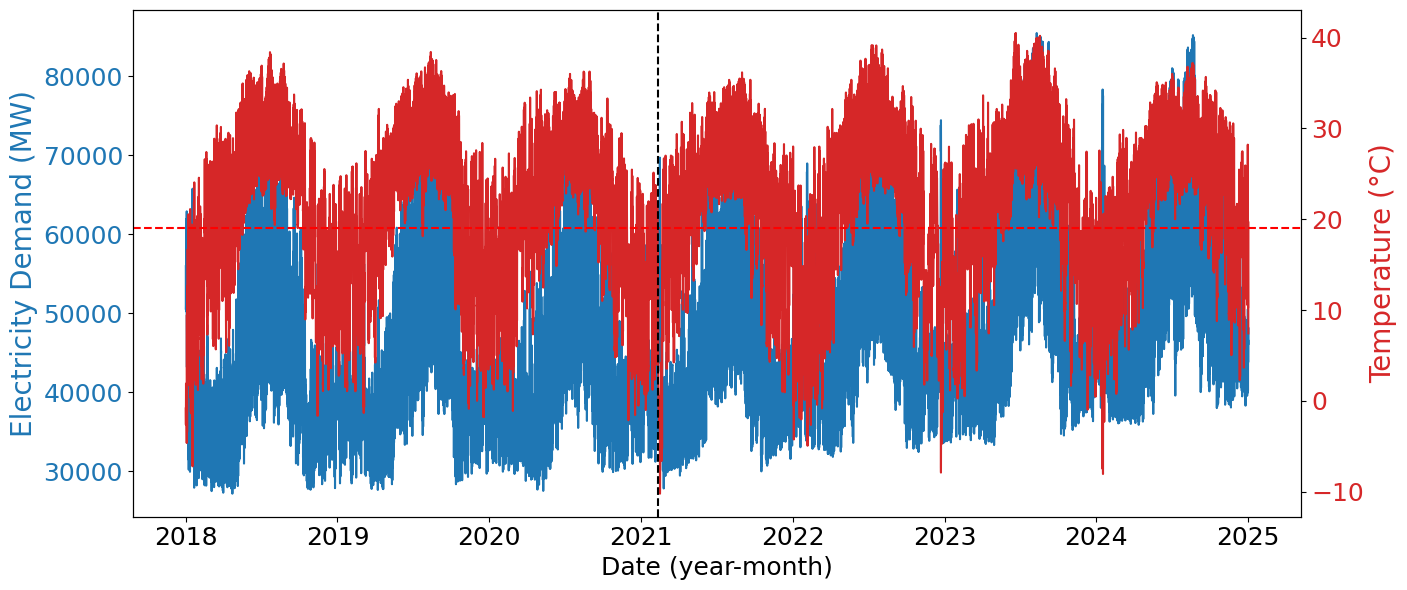

In [12]:
# Plot data
fig, ax1 = plt.subplots(figsize=(14,6), linewidth=2)

color = 'tab:blue'
ax1.set_xlabel('Date (year-month)',fontsize=18)
ax1.set_ylabel('Electricity Demand (MW)', fontsize=20, color=color)
ax1.plot(df.index, df['ERCOT'], '-', color=color)
ax1.tick_params(axis='y',  labelsize=18, labelcolor=color)
ax1.tick_params(axis='x',  labelsize=18)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperature (°C)', fontsize=20,color=color)
ax2.plot(df.index, df['tmpc'], '-', color=color)
ax2.tick_params(axis='y',  labelsize=12, labelcolor=color)
# plt.xlim(datetime.datetime(2020, 5, 1), datetime.datetime(2020, 10, 1))
fig.tight_layout()
ax2.axhline(y=19, ls='--', color='red')
plt.axvline(x=datetime.datetime(2021,2,10,12,0,0), ls='--',color='black')

#plt.show()

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
folder='C:/Users/mithu.debnath/Documents/Python_scripts/ERCOT_Electricity_Forecast-main/'
# filename= folder +'Fig1_test_data.png'
# plt.savefig(filename,dpi=400, bbox_inches='tight', format='png')

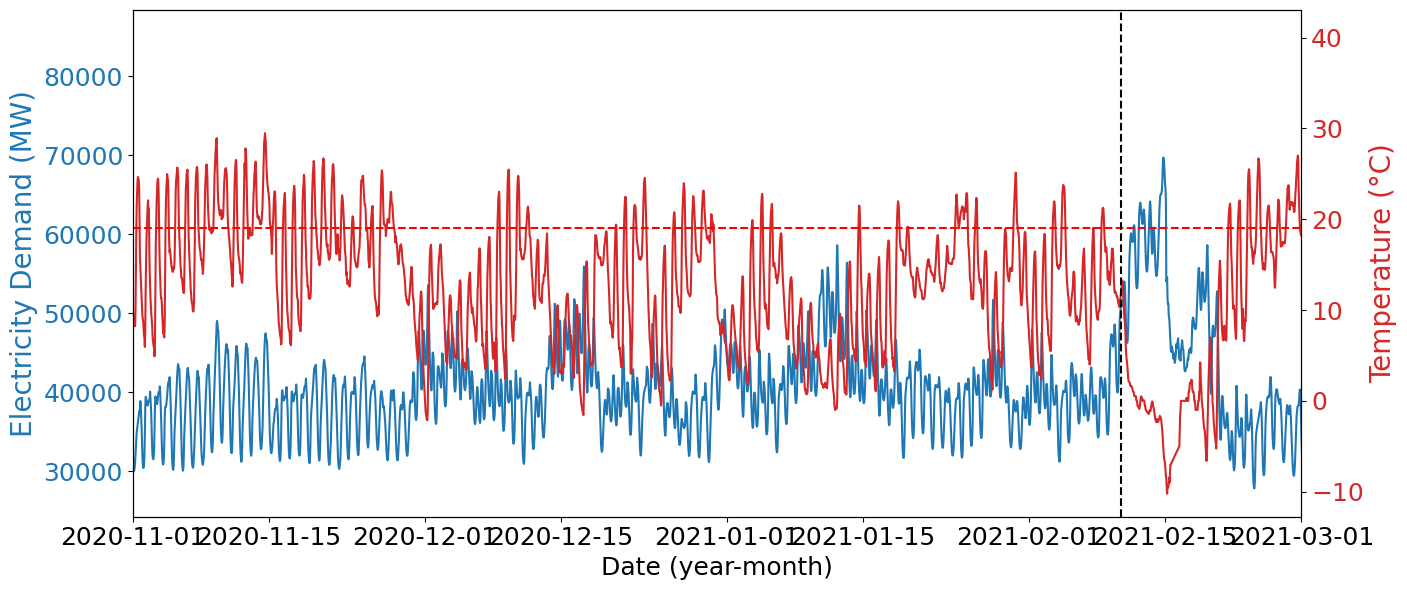

In [14]:
# Plot data
fig, ax1 = plt.subplots(figsize=(14,6), linewidth=2)

color = 'tab:blue'
ax1.set_xlabel('Date (year-month)',fontsize=18)
ax1.set_ylabel('Electricity Demand (MW)', fontsize=20, color=color)
ax1.plot(df.index, df['ERCOT'], '-', color=color)
ax1.tick_params(axis='y',  labelsize=18, labelcolor=color)
ax1.tick_params(axis='x',  labelsize=18)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperature (°C)', fontsize=20,color=color)
ax2.plot(df.index, df['tmpc'], '-', color=color)
ax2.tick_params(axis='y',  labelsize=12, labelcolor=color)
# plt.xlim(datetime.datetime(2020, 5, 1), datetime.datetime(2020, 10, 1))
fig.tight_layout()
ax2.axhline(y=19, ls='--', color='red')
plt.axvline(x=datetime.datetime(2021,2,10,12,0,0), ls='--',color='black')

#plt.show()

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(datetime.datetime(2020,11,1), datetime.datetime(2021,3,1) )
folder='C:/Users/mithu.debnath/Documents/Python_scripts/ERCOT_Electricity_Forecast-main/'
# filename= folder +'Fig1_test_data.png'
# plt.savefig(filename,dpi=400, bbox_inches='tight', format='png')

In [16]:
def remove_nan(x0,y0):
    mask = ~np.isnan(x0) & ~np.isnan(y0)
    x=x0[mask]
    y=y0[mask]
    return x,y

In [18]:
def bin_averaged(x0,y0,bin_number,substract=0.1):
    from scipy import stats
    mask = ~np.isnan(x0) & ~np.isnan(y0)
    x=x0[mask]
    y=y0[mask]
    bins = np.linspace(np.min(x)-substract,np.max(x)-substract,bin_number)
    #bins = np.linspace(1,26,bin_number)
    bin_centers = (bins [:-1] + bins [1:])/2
    bin_mean_shear, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='mean', bins=bins)
    bin_median_shear, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='median', bins=bins)
    bin_std_shear, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='std', bins=bins)
    return bin_centers, bin_mean_shear, bin_median_shear, bin_std_shear

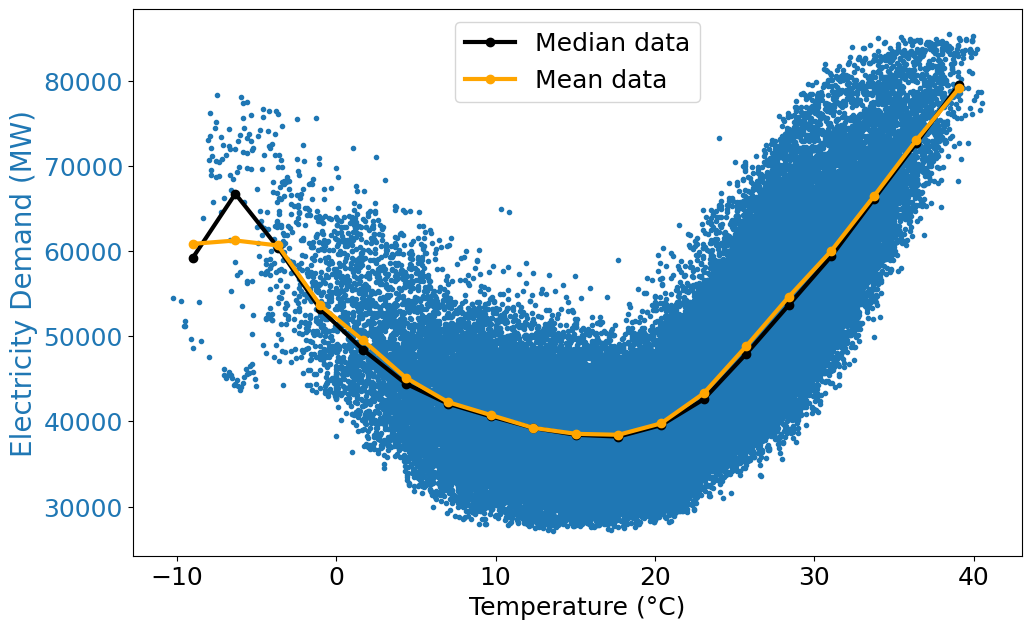

In [28]:
# Plot data
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.plot(df['tmpc'],df['ERCOT'], '.', color=color)
x=df['tmpc']
y=df['ERCOT']

bin_centers, bin_mean, bin_median, bin_std=bin_averaged(x,y,20,substract=0.1)

ax1.plot(bin_centers,bin_median,'-o', lw=3, color='Black', label='Median data')
ax1.plot(bin_centers,bin_mean,'-o', lw=3, color='orange', label='Mean data')


ax1.tick_params(axis='y', labelsize=16, labelcolor=color)
fig.tight_layout()
ax1.set_xlabel('Temperature (°C)',fontsize=18)
ax1.set_ylabel('Electricity Demand (MW)', fontsize=20, color=color)
#ax1.axhline(y=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

# filename= folder +'Fig2_relation.png'
# plt.savefig(filename,dpi=400, bbox_inches='tight', format='png')


C:\Users\sajib\AppData\Local\Temp\ipykernel_3840\2006474248.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.0001)
C:\Users\sajib\AppData\Local\Temp\ipykernel_3840\2006474248.py:71: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.0001)


Text(2.3148148148148147e-05, 3, '12-hour')

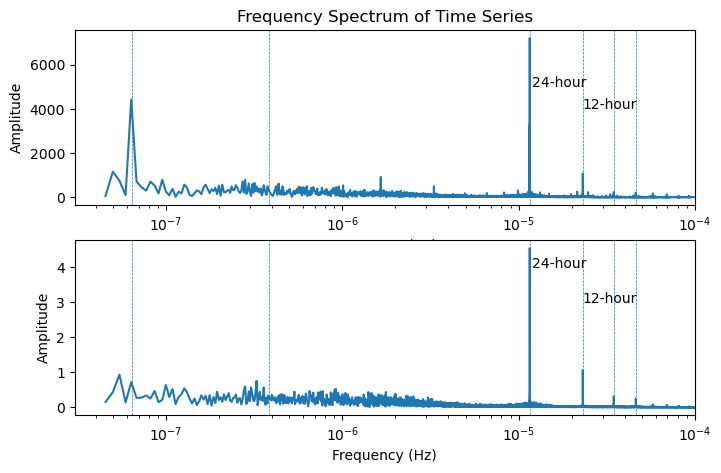

In [32]:
from scipy.fft import fft, fftfreq
## Spectral analysis
# from scipy.fft import fft, fftfreq

fig=plt.figure(figsize=(8,5))

fig.add_subplot(211)
sampling_rate=1/(60*60)
N = len(df['tmpc'])  # Number of samples
N1=len(df['ERCOT'])
yf = fft(df['tmpc'].values) # Perform FFT
yf1=fft(df['ERCOT'].values) # Perform FFT
xf = fftfreq(N, 1/sampling_rate) # Get corresponding frequencies


# plt.plot(xf[10:N//2], 2.0/N * np.abs(yf[10:N//2])) # Plot positive frequencies and their magnitudes
plt.plot(xf[10:N//2], 2.0/N * np.abs(yf1[10:N//2])) # Plot positive frequencies and their magnitudes
plt.title('Frequency Spectrum of Time Series')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
# plt.grid(True)

plt.axvline(x=1/(24*182*3600), ls='--', lw=0.5)

plt.axvline(x=1/(24*30*3600), ls='--', lw=0.5)
plt.axvline(x=1/(24*3600), ls='--', lw=0.5)
plt.axvline(x=1/(12*3600), ls='--', lw=0.5)

plt.axvline(x=1/(8*3600), ls='--', lw=0.5)
plt.axvline(x=1/(6*3600), ls='--', lw=0.5)


plt.xscale('log')
plt.xlim(0, 0.0001)

plt.text(1.184074074074073e-05, 5000, '24-hour')
plt.text(2.3148148148148147e-05, 4000, '12-hour')




fig.add_subplot(212)
sampling_rate=1/(60*60)
N = len(df['tmpc'])  # Number of samples
N1=len(df['ERCOT'])
yf = fft(df['tmpc'].values) # Perform FFT
yf1=fft(df['ERCOT'].values) # Perform FFT
xf = fftfreq(N, 1/sampling_rate) # Get corresponding frequencies



plt.plot(xf[10:N//2], 2.0/N * np.abs(yf[10:N//2])) # Plot positive frequencies and their magnitudes
# plt.plot(xf[10:N//2], 2.0/N * np.abs(yf1[10:N//2])) # Plot positive frequencies and their magnitudes
# plt.title('Frequency Spectrum of Time Series')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
# plt.grid(True)


plt.axvline(x=1/(24*182*3600), ls='--', lw=0.5)

plt.axvline(x=1/(24*30*3600), ls='--', lw=0.5)
plt.axvline(x=1/(24*3600), ls='--', lw=0.5)
plt.axvline(x=1/(12*3600), ls='--', lw=0.5)

plt.axvline(x=1/(8*3600), ls='--', lw=0.5)
plt.axvline(x=1/(6*3600), ls='--', lw=0.5)


plt.xscale('log')
plt.xlim(0, 0.0001)

plt.text(1.184074074074073e-05, 4, '24-hour')
plt.text(2.3148148148148147e-05, 3, '12-hour')


In [34]:
1/(24*3600)

1.1574074074074073e-05

## Identify the extreme events

In [37]:
df['ERCOT']

timestamp
2018-01-01 01:00:00    50567.069682
2018-01-01 02:00:00    50617.087977
2018-01-01 03:00:00    50694.300087
2018-01-01 04:00:00    50999.591693
2018-01-01 05:00:00    51723.732017
                           ...     
2024-12-31 20:00:00    47619.264355
2024-12-31 21:00:00    46737.678611
2024-12-31 22:00:00    45775.649767
2024-12-31 23:00:00    44779.606498
2025-01-01 00:00:00    43892.434849
Name: ERCOT, Length: 61368, dtype: float64

In [39]:

def hampel_filter(data, window_size, n_sigmas=3):
    """
    Detects outliers in a time series using the Hampel filter.

    Args:
        data (pd.Series): Time series data.
        window_size (int): Size of the sliding window.
        n_sigmas (float): Number of standard deviations (expressed as MAD) to flag outliers.

    Returns:
        pd.Series: Boolean series indicating outliers (True) and non-outliers (False).
    """
    
    data_pandas = pd.Series(data)
    
    half_window = window_size // 2
    
    medians = data_pandas.rolling(window_size, center=True).median()
    
    mad = lambda x: np.median(np.abs(x - np.median(x)))
    mads = data_pandas.rolling(window_size, center=True).apply(mad, raw=True)
    
    thresholds = n_sigmas * 1.4826 * mads
    
    outliers = np.abs(data_pandas - medians) > thresholds
    
    return outliers

In [41]:
# actual_demand_df_2023 = pd.read_csv('var/2023_electricity_demand_data.csv') 
# actual_demand_df_2023['timestamp'] = pd.to_datetime(actual_demand_df_2023['timestamp'])
# actual_demand_df_2023.set_index('timestamp', inplace=True)

# df_with2023=pd.concat([df['ERCOT'],actual_demand_df_2023['ERCOT']])

In [43]:
df

,tmpc,relh,sped,feel,p01m,mslp,ice_accretion_1hr,ERCOT
timestamp,,,,,,,,
2018-01-01 01:00:00,-0.833333,91.393333,12.777778,20.792222,0.0,NaN,NaN,50567.069682
2018-01-01 02:00:00,-1.284444,90.400000,12.266667,20.203333,0.0,NaN,NaN,50617.087977
2018-01-01 03:00:00,-1.752222,91.590000,11.883333,19.276667,0.0,NaN,NaN,50694.300087
2018-01-01 04:00:00,-1.895556,90.946667,12.905556,18.685556,0.0,NaN,NaN,50999.591693
2018-01-01 05:00:00,-1.968889,89.366667,12.394444,18.707778,0.0,NaN,NaN,51723.732017
...,...,...,...,...,...,...,...,...
2024-12-31 20:00:00,10.124444,54.446667,3.577778,49.871111,0.0,1013.900000,NaN,47619.264355
2024-12-31 21:00:00,9.574444,63.366667,5.494444,47.508889,0.0,1014.366667,NaN,46737.678611
2024-12-31 22:00:00,8.994444,64.966667,6.388889,46.236667,0.0,1014.833333,NaN,45775.649767


In [45]:
df_mean = df['ERCOT'].resample('Y',closed='left').mean()

C:\Users\sajib\AppData\Local\Temp\ipykernel_3840\1941758236.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_mean = df['ERCOT'].resample('Y',closed='left').mean()


In [47]:
df_mean.index=df_mean.index -timedelta(days=180, hours=0, minutes=0)

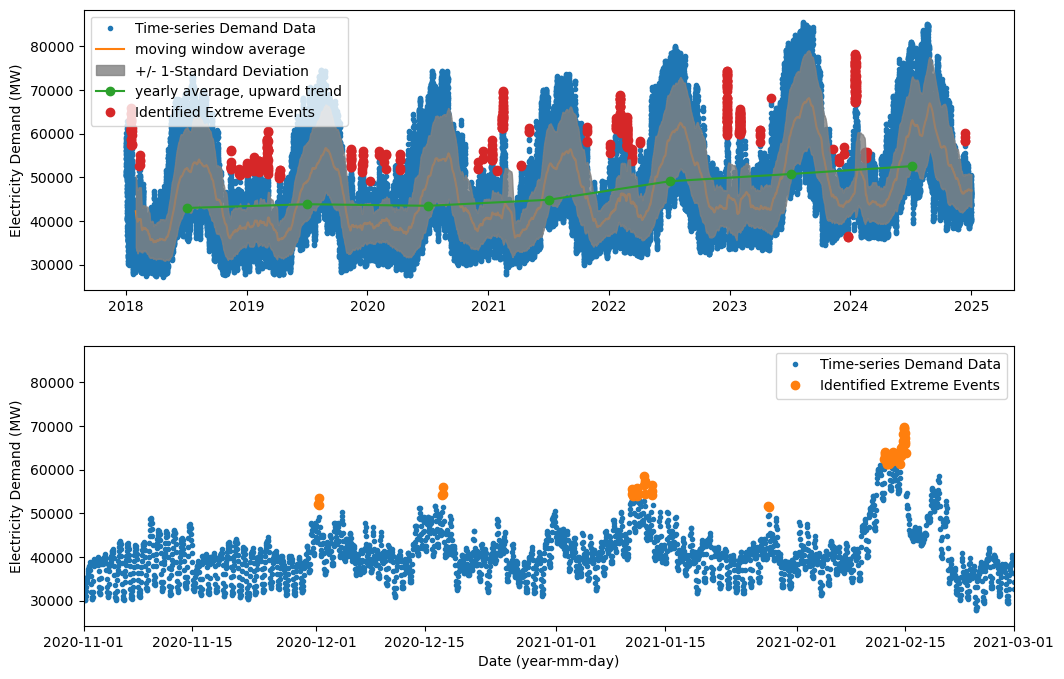

In [49]:
window_size = 24*30 # Define the window size for the moving average
df['ERCOT_avg'] = df['ERCOT'].rolling(window=window_size).mean()
df['ERCOT_std'] = df['ERCOT'].rolling(window=window_size).std()

fig=plt.figure(figsize=(12,8))
fig.add_subplot(211)
plt.plot(df['ERCOT'],'.', label='Time-series Demand Data', zorder=1)
plt.plot(df['ERCOT_avg'],label='moving window average', zorder=1)

plt.fill_between(df['ERCOT'].index, df['ERCOT_avg'] - df['ERCOT_std'], df['ERCOT_avg'] + df['ERCOT_std'], color='gray', alpha=0.8, label='+/- 1-Standard Deviation', zorder=2)

plt.plot(df_mean[:-1],'o-', label='yearly average, upward trend')

kk=hampel_filter(df['ERCOT'], window_size=30*24, n_sigmas=3)
plt.plot(df['ERCOT'][kk],'o', label='Identified Extreme Events',zorder=1)

plt.ylabel('Electricity Demand (MW)')
plt.legend()
fig.add_subplot(212)
plt.plot(df['ERCOT'],'.', label='Time-series Demand Data')
kk=hampel_filter(df['ERCOT'], window_size=30*24, n_sigmas=3)
plt.plot(df['ERCOT'][kk],'o', label='Identified Extreme Events')

plt.ylabel('Electricity Demand (MW)')
plt.xlabel('Date (year-mm-day)')
plt.xlim(datetime.datetime(2020,11,1), datetime.datetime(2021,3,1) )
plt.legend()
# Save the plot as an image
# plt.savefig('extreme_event_time_series.png', dpi=300)

In [51]:
df_all=df.copy()

In [53]:
## Seperate the 2024 data
index=(df.index < datetime.datetime(2024,1,1))
df=df_all.loc[index]
index=(df_all.index >= datetime.datetime(2024,1,1))
df_2024=df_all[index]
df_2024=df_2024[:-1]

In [55]:
df_2024

,tmpc,relh,sped,feel,p01m,mslp,ice_accretion_1hr,ERCOT,ERCOT_avg,ERCOT_std
timestamp,,,,,,,,,,
2024-01-01 00:00:00,10.815556,100.000000,2.938889,49.870000,0.0,1014.033333,NaN,41621.968883,44779.680262,3419.456421
2024-01-01 01:00:00,9.833333,100.000000,4.663889,47.723333,0.0,1014.233333,NaN,41223.480177,44781.065587,3417.810689
2024-01-01 02:00:00,9.338889,100.000000,4.216667,46.966667,0.0,1014.566667,NaN,41479.399746,44784.076555,3413.938226
2024-01-01 03:00:00,9.024444,100.000000,3.833333,46.178889,0.0,1014.833333,NaN,41472.770126,44787.693414,3409.038403
2024-01-01 04:00:00,9.018889,100.000000,3.322222,46.141111,0.0,1014.866667,NaN,41477.440791,44791.673208,3403.486788
...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,11.383333,44.713333,3.961111,52.488889,0.0,1012.966667,NaN,48175.877538,46960.515029,3741.270801
2024-12-31 20:00:00,10.124444,54.446667,3.577778,49.871111,0.0,1013.900000,NaN,47619.264355,46959.480022,3740.984930
2024-12-31 21:00:00,9.574444,63.366667,5.494444,47.508889,0.0,1014.366667,NaN,46737.678611,46957.808868,3740.814648


In [57]:
df_all

,tmpc,relh,sped,feel,p01m,mslp,ice_accretion_1hr,ERCOT,ERCOT_avg,ERCOT_std
timestamp,,,,,,,,,,
2018-01-01 01:00:00,-0.833333,91.393333,12.777778,20.792222,0.0,NaN,NaN,50567.069682,NaN,NaN
2018-01-01 02:00:00,-1.284444,90.400000,12.266667,20.203333,0.0,NaN,NaN,50617.087977,NaN,NaN
2018-01-01 03:00:00,-1.752222,91.590000,11.883333,19.276667,0.0,NaN,NaN,50694.300087,NaN,NaN
2018-01-01 04:00:00,-1.895556,90.946667,12.905556,18.685556,0.0,NaN,NaN,50999.591693,NaN,NaN
2018-01-01 05:00:00,-1.968889,89.366667,12.394444,18.707778,0.0,NaN,NaN,51723.732017,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-12-31 20:00:00,10.124444,54.446667,3.577778,49.871111,0.0,1013.900000,NaN,47619.264355,46959.480022,3740.984930
2024-12-31 21:00:00,9.574444,63.366667,5.494444,47.508889,0.0,1014.366667,NaN,46737.678611,46957.808868,3740.814648
2024-12-31 22:00:00,8.994444,64.966667,6.388889,46.236667,0.0,1014.833333,NaN,45775.649767,46956.044907,3741.072579


In [59]:
## Seperate the 2024 data
index=(df_all.index < datetime.datetime(2024,1,1))
df=df_all.loc[index]
index=(df_all.index >= datetime.datetime(2024,1,1))
df_2024=df_all[index]
df_2024=df_2024[:-1]

In [61]:
df_2024

,tmpc,relh,sped,feel,p01m,mslp,ice_accretion_1hr,ERCOT,ERCOT_avg,ERCOT_std
timestamp,,,,,,,,,,
2024-01-01 00:00:00,10.815556,100.000000,2.938889,49.870000,0.0,1014.033333,NaN,41621.968883,44779.680262,3419.456421
2024-01-01 01:00:00,9.833333,100.000000,4.663889,47.723333,0.0,1014.233333,NaN,41223.480177,44781.065587,3417.810689
2024-01-01 02:00:00,9.338889,100.000000,4.216667,46.966667,0.0,1014.566667,NaN,41479.399746,44784.076555,3413.938226
2024-01-01 03:00:00,9.024444,100.000000,3.833333,46.178889,0.0,1014.833333,NaN,41472.770126,44787.693414,3409.038403
2024-01-01 04:00:00,9.018889,100.000000,3.322222,46.141111,0.0,1014.866667,NaN,41477.440791,44791.673208,3403.486788
...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,11.383333,44.713333,3.961111,52.488889,0.0,1012.966667,NaN,48175.877538,46960.515029,3741.270801
2024-12-31 20:00:00,10.124444,54.446667,3.577778,49.871111,0.0,1013.900000,NaN,47619.264355,46959.480022,3740.984930
2024-12-31 21:00:00,9.574444,63.366667,5.494444,47.508889,0.0,1014.366667,NaN,46737.678611,46957.808868,3740.814648


In [63]:
df=df_all[0:4000]